In [1]:
import numpy as np
import pandas as pd
import math
import sys

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer, FeatureHasher
from sklearn.linear_model import RidgeClassifier
from sklearn.manifold import Isomap 
from sklearn.manifold import MDS
from sklearn.manifold import TSNE 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn import manifold 

from time import time

from umap import UMAP

In [2]:
adult_test_df = pd.read_csv('datasets/benchmark/adult_clean_test.csv')
adult_train_df = pd.read_csv('datasets/benchmark/adult_clean_train.csv')
titanic_test_df = pd.read_csv('datasets/benchmark/titanic_clean_test.csv')
titanic_train_df = pd.read_csv('datasets/benchmark/titanic_clean_train.csv')
weather_test_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_test.csv')
weather_train_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_train.csv')
wine_test_df = pd.read_csv('datasets/benchmark/wine_test.csv')
wine_train_df = pd.read_csv('datasets/benchmark/wine_train.csv')

In [3]:
def extract_X_y(df, col_y):
    X = df.drop(col_y, axis=1)
    y = df[col_y]
    return X, y

In [4]:
adult_test_X, adult_test_y = extract_X_y(adult_test_df, 'income_>50k')
adult_train_X, adult_train_y = extract_X_y(adult_train_df, 'income_>50k')

titanic_test_X, titanic_test_y = extract_X_y(titanic_test_df, 'Survived')
titanic_train_X, titanic_train_y = extract_X_y(titanic_train_df, 'Survived')

weather_test_X, weather_test_y = extract_X_y(weather_test_df, 'RainTomorrow')
weather_train_X, weather_train_y = extract_X_y(weather_train_df, 'RainTomorrow')

wine_test_X, wine_test_y = extract_X_y(wine_test_df, 'quality')
wine_train_X, wine_train_y = extract_X_y(wine_train_df, 'quality')

In [5]:
print(adult_test_X.shape)
print(adult_train_X.shape)

(9769, 92)
(39073, 92)


In [6]:
print(titanic_test_X.shape)
print(titanic_train_X.shape)

(262, 20)
(1047, 20)


In [7]:
print(weather_test_X.shape)
print(weather_train_X.shape)

(24358, 29)
(97432, 29)


In [8]:
print(wine_test_X.shape)
print(wine_train_X.shape)

(320, 11)
(1279, 11)


In [9]:
# adult_test_iso_X = Isomap(n_neighbors=10, n_jobs=-1).fit_transform(adult_test_X.values) # n_components=2

In [10]:
# adult_test_tsne_X = TSNE().fit_transform(adult_test_X.values) # n_components=2

In [11]:
# adult_test_umap_X = UMAP().fit_transform(adult_test_X.values) #n_components=2

In [12]:
# adult_test_mds_X = MDS().fit_transform(adult_test_X.values) # n_components=2, 

In [13]:
def compute_score(model, test_X, test_y):
    pred = model.predict(test_X)
    acc = accuracy_score(pred, test_y)
    f1 = f1_score(pred, test_y)
    conf = confusion_matrix(pred, test_y)

    return acc, f1, conf

In [14]:
def fit_compute_score(model, train_X, train_y, test_X, test_y):
    t0 = time()
    model.fit(train_X, train_y)
    duration = time() - t0
    train_acc, train_f1, train_conf = compute_score(model, train_X, train_y)
    test_acc, test_f1, test_conf = compute_score(model, test_X, test_y)
    print("duration", duration)
    print("train accuracy", train_acc)
    print("train f1", train_f1)
    print("train tn, fp, fn, tp", train_conf.ravel()) 
    print("test accuracy", test_acc)
    print("test f1", test_f1)
    print("test tn, fp, fn, tp", test_conf.ravel())
    print()
    
    return train_acc, train_f1, train_conf, test_acc, test_f1, test_conf

In [15]:
def evaluate_reduction(model_factory, model_name, train_X, train_y, test_X, test_y):
    clf_ridge_default = RidgeClassifier()
    print('ridge_default')
    ridge_default_train_acc, ridge_default_train_f1, ridge_default_train_conf, \
        ridge_default_test_acc, ridge_default_test_f1, ridge_default_test_conf = \
        fit_compute_score(clf_ridge_default, train_X, train_y, test_X, test_y)

    n_estimators = 1000
    clf_randfor_default = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
    print('randfor_default')
    randfor_default_train_acc, randfor_default_train_f1, randfor_default_train_conf, \
        randfor_default_test_acc, randfor_default_test_f1, randfor_default_test_conf = \
        fit_compute_score(clf_randfor_default, train_X, train_y, test_X, test_y)

    ridge_train_acc = []
    ridge_train_f1 = []
    ridge_train_conf = []
    ridge_test_acc = []
    ridge_test_f1 = []
    ridge_test_conf = []
    
    randfor_train_acc = []
    randfor_train_f1 = []
    randfor_train_conf = []
    randfor_test_acc = []
    randfor_test_f1 = []
    randfor_test_conf = []

    for i in range(2, 11, 2):
        percent = 0.1*i
        n_features = math.ceil(train_X.shape[1]*percent)

        t0 = time()
        reduction_model = model_factory(n_features)
        train_X_reduced = reduction_model.fit_transform(train_X)
        test_X_reduced  = reduction_model.fit_transform(test_X)
        duration = time() - t0
        print("transform duration", duration, "reduce percent", percent, "n_features", n_features)
        print()

        clf_ridge_hash = RidgeClassifier()
        ridge_name = 'ridge_' + model_name
        print(ridge_name)
        ridge_hash_train_acc, ridge_hash_train_f1, ridge_hash_train_conf, \
            ridge_hash_test_acc, ridge_hash_test_f1, ridge_hash_test_conf = \
            fit_compute_score(clf_ridge_hash, train_X_reduced, train_y, test_X_reduced, test_y)
        ridge_train_acc.append(ridge_hash_train_acc)
        ridge_train_f1.append(ridge_hash_train_f1)
        ridge_train_conf.append(ridge_hash_train_conf)
        ridge_test_acc.append(ridge_hash_test_acc)
        ridge_test_f1.append(ridge_hash_test_f1)
        ridge_test_conf.append(ridge_hash_test_conf)

        clf_randfor_hash = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
        randfor_name = 'randfor_' + model_name
        print(randfor_name)
        randfor_hash_train_acc, randfor_hash_train_f1, randfor_hash_train_conf, \
            randfor_hash_test_acc, randfor_hash_test_f1, randfor_hash_test_conf = \
            fit_compute_score(clf_randfor_hash, train_X_reduced, train_y, test_X_reduced, test_y)
        randfor_train_acc.append(randfor_hash_train_acc)
        randfor_train_f1.append(randfor_hash_train_f1)
        randfor_train_conf.append(randfor_hash_train_conf)
        randfor_test_acc.append(randfor_hash_test_acc)
        randfor_test_f1.append(randfor_hash_test_f1)
        randfor_test_conf.append(randfor_hash_test_conf)
    
    t = np.arange(2, 11, 2)

    fig, ax = plt.subplots(2, 2, figsize=(15,10), tight_layout=True)
    
    ax[0,0].plot(t, ridge_default_train_acc*np.ones(5), label='ridge_default')
    ax[0,0].plot(t, randfor_default_train_acc*np.ones(5), label='randfor_default')
    ax[0,0].plot(t, ridge_train_acc, label=ridge_name)
    ax[0,0].plot(t, randfor_train_acc, label=randfor_name)
    ax[0,0].set(xlabel='reduce %', ylabel='accuracy', title='train')
    ax[0,0].legend()

    ax[0,1].plot(t, ridge_default_test_acc*np.ones(5), label='ridge_default')
    ax[0,1].plot(t, randfor_default_test_acc*np.ones(5), label='randfor_default')
    ax[0,1].plot(t, ridge_test_acc, label=ridge_name)
    ax[0,1].plot(t, randfor_test_acc, label=randfor_name)
    ax[0,1].set(xlabel='reduce %', ylabel='accuracy', title='test')
    ax[0,1].legend()
    
    ax[1,0].plot(t, ridge_default_train_f1*np.ones(5), label='ridge_default')
    ax[1,0].plot(t, randfor_default_train_f1*np.ones(5), label='randfor_default')
    ax[1,0].plot(t, ridge_train_f1, label=ridge_name)
    ax[1,0].plot(t, randfor_train_f1, label=randfor_name)
    ax[1,0].set(xlabel='reduce %', ylabel='f1', title='train')
    ax[1,0].legend()
    
    ax[1,1].plot(t, ridge_default_test_f1*np.ones(5), label='ridge_default')
    ax[1,1].plot(t, randfor_default_test_f1*np.ones(5), label='randfor_default')
    ax[1,1].plot(t, ridge_test_f1, label=ridge_name)
    ax[1,1].plot(t, randfor_test_f1, label=randfor_name)
    ax[1,1].set(xlabel='reduce %', ylabel='f1', title='test')
    ax[1,1].legend()

    plt.show()

In [ ]:
# computer die

In [ ]:
# n_neighbors = 15 because warning
# evaluate_reduction(lambda n: Isomap(n_neighbors=15, n_jobs=-1, n_components=n), "iso", adult_train_X, adult_train_y, adult_test_X, adult_test_y)

ridge_default
duration 0.16997051239013672
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_default
duration 14.219999551773071
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8553587880028662
test f1 0.6773235898606988
test tn, fp, fn, tp [6873  924  489 1483]



In [ ]:
# TSNE tool to visualize high-dimensional data

In [16]:
# evaluate_reduction(lambda n: TSNE(n_jobs=-1, n_components=n), "tse", adult_train_X, adult_train_y, adult_test_X, adult_test_y)

ridge_default
duration 0.14799809455871582
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_default
duration 15.0390145778656
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8551540587572934
test f1 0.6765714285714286
test tn, fp, fn, tp [6874  927  488 1480]



C:\Users\win_1\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\win_1\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.

ridge_default
duration 0.08599615097045898
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_default
duration 14.606998682022095
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8563824342307299
test f1 0.6794608179118118
test tn, fp, fn, tp [6879  920  483 1487]

transform duration 83.22889375686646 reduce percent 0.2 n_features 19

ridge_umap
duration 0.050000667572021484
train accuracy 0.7628797379264454
train f1 0.020509567607569508
train tn, fp, fn, tp [29711  9183    82    97]
test accuracy 0.7536083529532194
test f1 0.0
test tn, fp, fn, tp [7362 2407    0    0]

randfor_umap
duration 32.342997312545776
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [29793     0     0  9280]
test accuracy 0.24639164704678063
test f1 0.39536793692509

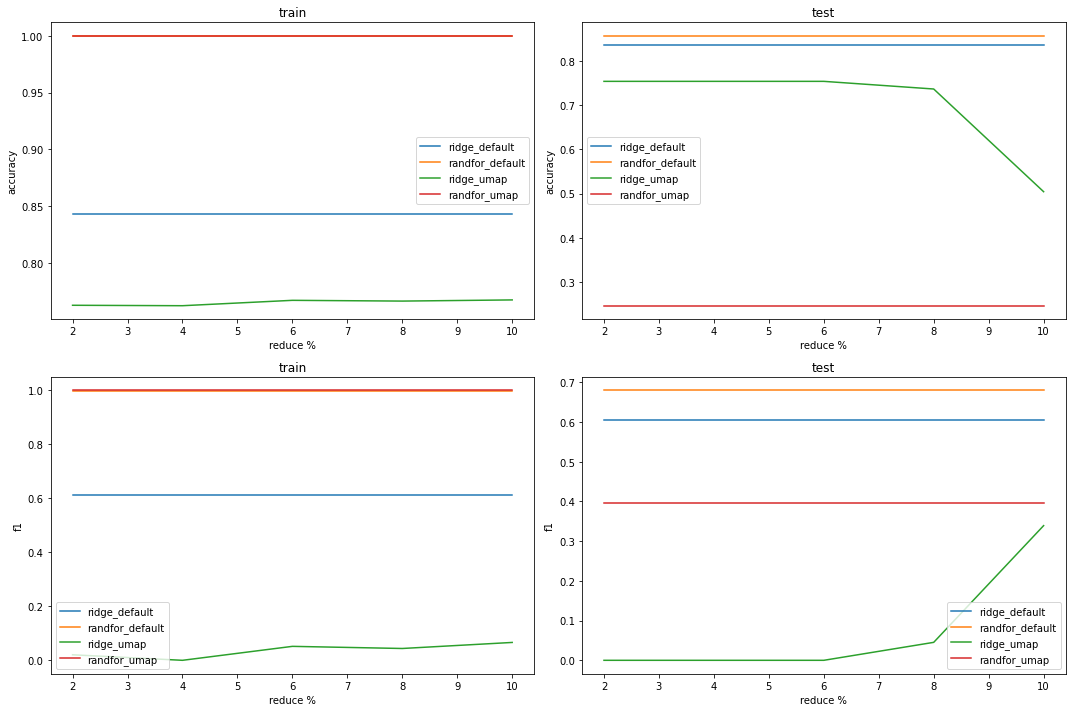

In [17]:
evaluate_reduction(lambda n: UMAP(n_jobs=-1, n_components=n), "umap", adult_train_X, adult_train_y, adult_test_X, adult_test_y)

In [ ]:
# computer die

In [18]:
evaluate_reduction(lambda n: MDS(n_jobs=-1, n_components=n), "mds", adult_train_X, adult_train_y, adult_test_X, adult_test_y)

ridge_default
duration 0.0749971866607666
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_default
duration 13.015000581741333
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8549493295117208
test f1 0.6762622801005255
test tn, fp, fn, tp [6872  927  490 1480]



MemoryError: Unable to allocate 11.4 GiB for an array with shape (39073, 39073) and data type float64